In [1]:
import pandas as pd

# 1) 정제된 데이터 다시 로드
df = pd.read_csv("total_clean.csv", parse_dates=["Date"])

# 2) 숫자 컬럼 타입 다시 한 번 확실히 맞추기
num_cols = ["CustomerID", "TotalCost", "Quantity", "EffectivePrice"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print(df.dtypes)
print(df.head())


CustomerID                 float64
Date                datetime64[ns]
MeterCategory               object
MeterSubCategory            object
MeterName                   object
ChargeType                  object
EffectivePrice             float64
MaskedSub                   object
Quantity                   float64
TotalCost                  float64
dtype: object
   CustomerID       Date     MeterCategory  \
0       100.0 2025-08-20  Virtual Machines   
1       100.0 2025-08-21  Virtual Machines   
2       100.0 2025-08-10  Virtual Machines   
3       100.0 2025-08-29  Virtual Machines   
4       100.0 2025-08-09  Virtual Machines   

                       MeterSubCategory MeterName ChargeType  EffectivePrice  \
0  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
1  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
2  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
3  Virtual Machines Dsv5 Series Windows

In [52]:
cust_id = 200  # 다른 고객 보고 싶으면 숫자만 바꾸면 됨

# 1) 해당 고객 데이터만 필터링 + 날짜별 TotalCost 합계
ts = (
    df[df["CustomerID"] == cust_id]
    .groupby("Date")["TotalCost"]
    .sum()
    .sort_index()
)

print("고객 ID:", cust_id)
print("데이터 포인트 개수:", len(ts))
print(ts.head())
print("날짜 범위:", ts.index.min(), "~", ts.index.max())


고객 ID: 200
데이터 포인트 개수: 184
Date
2025-05-01    7.992968e+06
2025-05-02    8.277856e+06
2025-05-03    7.739332e+06
2025-05-04    1.122942e+07
2025-05-05    1.482471e+07
Name: TotalCost, dtype: float64
날짜 범위: 2025-05-01 00:00:00 ~ 2025-10-31 00:00:00


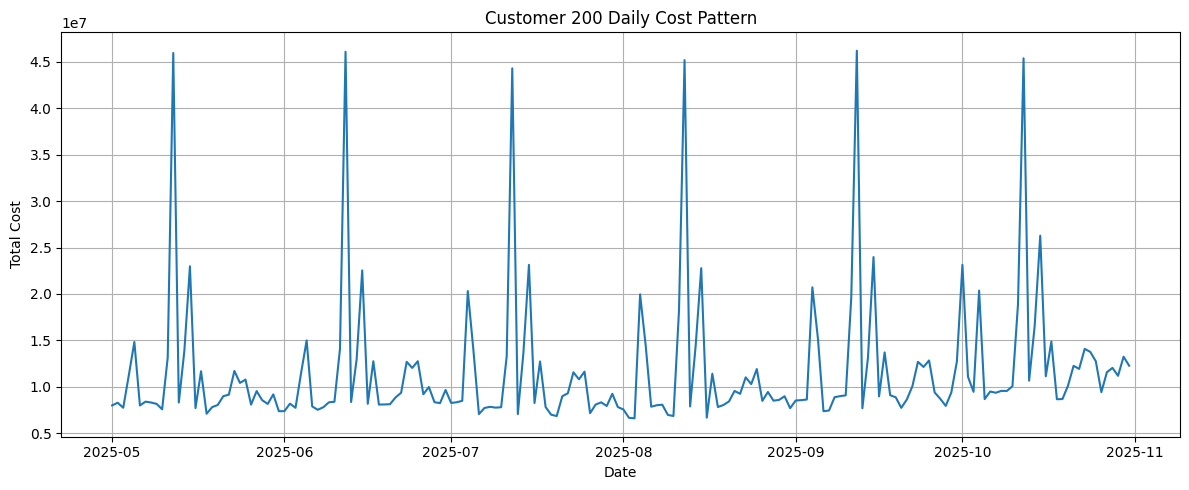

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values)
plt.title(f"Customer {cust_id} Daily Cost Pattern")
plt.xlabel("Date")
plt.ylabel("Total Cost")
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
split_point = int(len(ts) * 0.7)

train = ts.iloc[:split_point]
test  = ts.iloc[split_point:]

print("Train size:", len(train))
print("Test size :", len(test))
print("Train 기간:", train.index.min(), "~", train.index.max())
print("Test 기간 :", test.index.min(), "~", test.index.max())


Train size: 128
Test size : 56
Train 기간: 2025-05-01 00:00:00 ~ 2025-09-05 00:00:00
Test 기간 : 2025-09-06 00:00:00 ~ 2025-10-31 00:00:00


In [55]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

train_values = train.values.reshape(-1, 1)
test_values  = test.values.reshape(-1, 1)

train_scaled = scaler.fit_transform(train_values)
test_scaled  = scaler.transform(test_values)

print("✅ 정규화 완료")
print("train shape:", train_scaled.shape)
print("test shape :", test_scaled.shape)
print("train min/max:", train_scaled.min(), train_scaled.max())
print("test min/max :", test_scaled.min(), test_scaled.max())


✅ 정규화 완료
train shape: (128, 1)
test shape : (56, 1)
train min/max: 0.0 0.9999999999999999
test min/max : 0.019330114495177436 1.0027662439583125


In [56]:
# 슬라이딩 윈도우 생성 함수
def create_sequences(data, window_size=30):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

WINDOW_SIZE = 7

X_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test  = create_sequences(test_scaled, WINDOW_SIZE)

print("✅ 시퀀스 생성 완료")
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)


✅ 시퀀스 생성 완료
X_train shape: (121, 7, 1)
X_test shape : (49, 7, 1)


In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# 모델 구조 정의
model = Sequential([
    LSTM(32, activation="relu", input_shape=(WINDOW_SIZE, 1), return_sequences=False),
    RepeatVector(WINDOW_SIZE),
    LSTM(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

model.summary()


C:\dev\ds-playground\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_5 (RepeatVector)       │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 7, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 7, 1)                │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, X_train,          # 오토인코더라서 입력=정답
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stop]
)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0502 - val_loss: 0.0045
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0453 - val_loss: 0.0029
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0416 - val_loss: 0.0020
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0386 - val_loss: 0.0023
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0368 - val_loss: 0.0036
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0363 - val_loss: 0.0045
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0360 - val_loss: 0.0038
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0355 - val_loss: 0.0030


In [59]:
# 학습 데이터 재구성
X_train_pred = model.predict(X_train)

# 재구성 오차 (MSE)
train_mse = np.mean(np.square(X_train_pred - X_train), axis=(1,2))

print("Train reconstruction error statistics")
print("min:", train_mse.min())
print("max:", train_mse.max())
print("mean:", train_mse.mean())
print("std:", train_mse.std())

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
Train reconstruction error statistics
min: 0.00028423021148311965
max: 0.15203039711133523
mean: 0.03567227581985385
std: 0.05300277562886857


In [60]:
# ✅ 이상치 기준선 설정
threshold_3sigma = train_mse.mean() + 3 * train_mse.std()
threshold_15sigma = train_mse.mean() + 1.5 * train_mse.std()

print("Threshold (3σ):", threshold_3sigma)
print("Threshold (1.5σ):", threshold_15sigma)

anomaly_3sigma = test_mse > threshold_3sigma
anomaly_15sigma = test_mse > threshold_15sigma

dates_3sigma = test_dates[anomaly_3sigma]
dates_15sigma = test_dates[anomaly_15sigma]

print("\n[3σ 기준]")
print("이상 개수:", anomaly_3sigma.sum())
print("이상 날짜:", list(dates_3sigma))

print("\n[1.5σ 기준]")
print("이상 개수:", anomaly_15sigma.sum())
print("이상 날짜:", list(dates_15sigma))


Threshold (3σ): 0.19468060270645957
Threshold (1.5σ): 0.11517643926315671

[3σ 기준]
이상 개수: 0
이상 날짜: []

[1.5σ 기준]
이상 개수: 0
이상 날짜: []


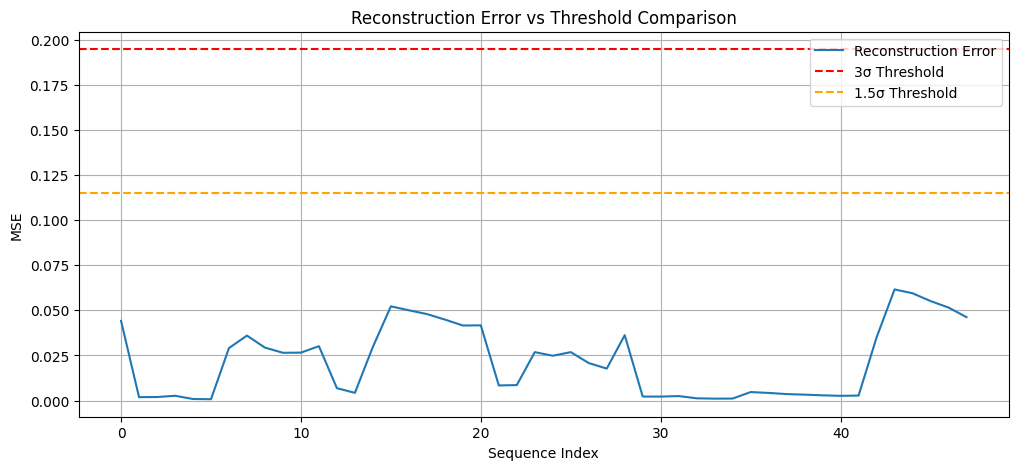

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_mse, label="Reconstruction Error")
plt.axhline(threshold_3sigma, color='red', linestyle='--', label="3σ Threshold")
plt.axhline(threshold_15sigma, color='orange', linestyle='--', label="1.5σ Threshold")

plt.title("Reconstruction Error vs Threshold Comparison")
plt.xlabel("Sequence Index")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# ✅ 일별 증감률 계산
ts_original = ts  # 정규화 전 원본 시계열

pct_change = ts_original.pct_change() * 100

# 기준: -30% 이하 감소를 anomaly로 설정
decrease_threshold = -30

decrease_anomalies = pct_change[pct_change < decrease_threshold]

print("📉 감소 이상 탐지 날짜 및 변화율:")
print(decrease_anomalies)


📉 감소 이상 탐지 날짜 및 변화율:
Date
2025-05-06   -46.149489
2025-05-13   -81.927723
2025-05-16   -66.469075
2025-05-18   -39.177432
2025-06-06   -47.430992
2025-06-13   -81.871861
2025-06-16   -63.751733
2025-06-18   -36.603442
2025-07-05   -31.058039
2025-07-06   -49.577793
2025-07-13   -84.078965
2025-07-16   -64.343576
2025-07-18   -38.578678
2025-07-26   -38.477953
2025-08-06   -45.788279
2025-08-13   -82.564354
2025-08-16   -70.699592
2025-08-18   -31.439453
2025-09-06   -51.530235
2025-09-13   -83.364889
2025-09-16   -62.617530
2025-09-18   -33.647503
2025-10-02   -52.103894
2025-10-05   -57.398691
2025-10-13   -76.520477
2025-10-16   -57.628238
2025-10-18   -41.768361
Name: TotalCost, dtype: float64


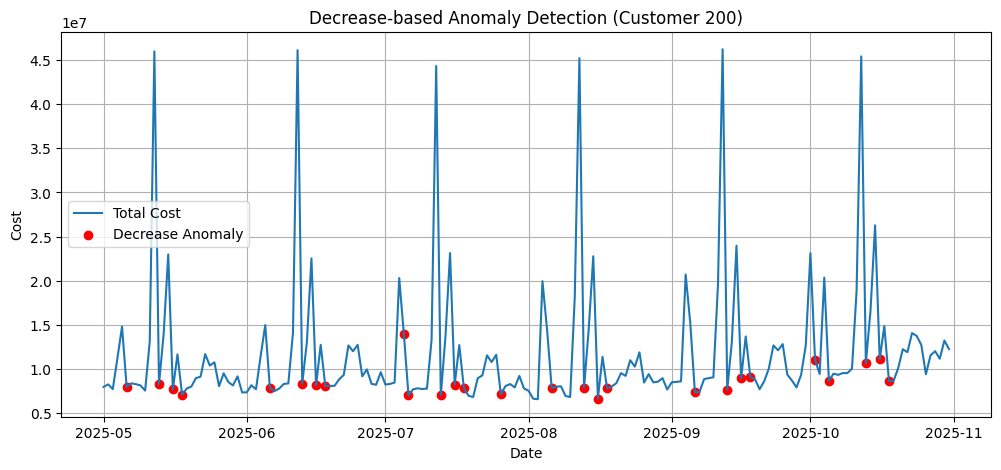

In [63]:
plt.figure(figsize=(12,5))
plt.plot(ts_original.index, ts_original.values, label="Total Cost")

plt.scatter(
    decrease_anomalies.index,
    ts_original.loc[decrease_anomalies.index],
    color="red",
    label="Decrease Anomaly"
)

plt.title(f"Decrease-based Anomaly Detection (Customer {cust_id})")
plt.xlabel("Date")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# 1) 테스트 시퀀스 재구성
X_test_pred = model.predict(X_test)

# 2) 재구성 오차(MSE) 계산
test_mse = np.mean(np.square(X_test_pred - X_test), axis=(1, 2))

print("Test reconstruction error statistics")
print("min :", test_mse.min())
print("max :", test_mse.max())
print("mean:", test_mse.mean())
print("std :", test_mse.std())

# 3) 기준선을 넘는 시퀀스(이상 후보) 개수
anomaly_flags = test_mse > threshold
print("\n기준선(threshold)을 초과한 시퀀스 수:", anomaly_flags.sum(), "/", len(test_mse))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test reconstruction error statistics
min : 0.0016907980587199463
max : 0.16254427430032733
mean: 0.050656305496710255
std : 0.05867420185971817

기준선(threshold)을 초과한 시퀀스 수: 14 / 49


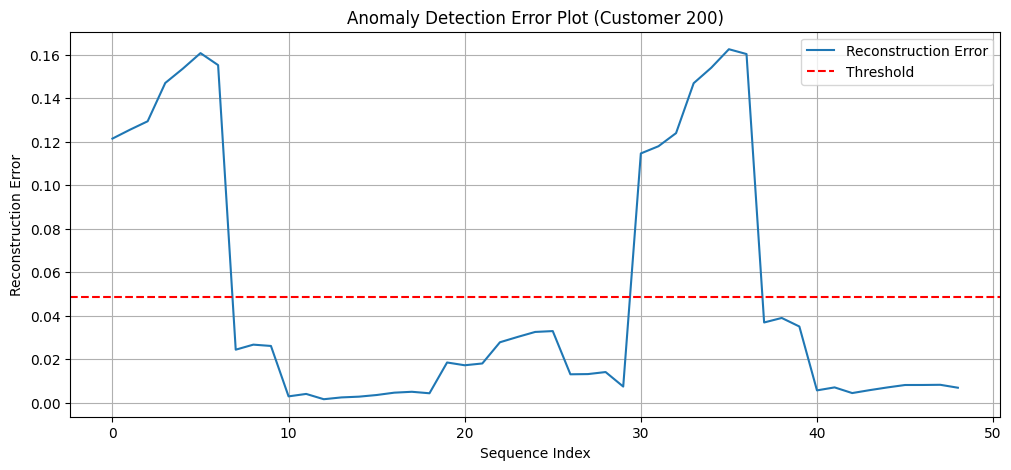

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_mse, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")

plt.title(f"Anomaly Detection Error Plot (Customer {cust_id})")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()


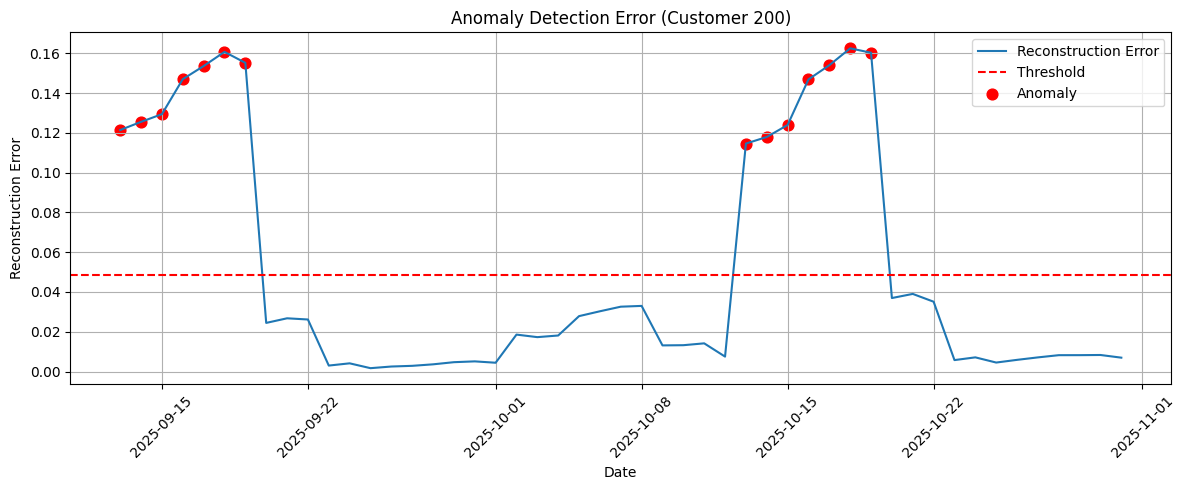

In [66]:
# 시퀀스에 대응되는 날짜 생성 (윈도우 마지막 날짜)
test_dates = ts.index[WINDOW_SIZE + split_point : WINDOW_SIZE + split_point + len(test_mse)]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_dates, test_mse, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")

# 이상치 위치 표시
anomaly_dates = test_dates[anomaly_flags]
anomaly_values = test_mse[anomaly_flags]
plt.scatter(anomaly_dates, anomaly_values, color="red", s=60, label="Anomaly")

plt.title(f"Anomaly Detection Error (Customer {cust_id})")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [67]:
# 이상치 발생 날짜 리스트
anomaly_dates = test_dates[anomaly_flags]
print("이상 발생 날짜:")
print(anomaly_dates)


이상 발생 날짜:
DatetimeIndex(['2025-09-13', '2025-09-14', '2025-09-15', '2025-09-16',
               '2025-09-17', '2025-09-18', '2025-09-19', '2025-10-13',
               '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17',
               '2025-10-18', '2025-10-19'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [68]:
combined_anomaly_dates = set(dates_15sigma) & set(decrease_anomalies.index)
print("공통 이상 날짜:", sorted(combined_anomaly_dates))


공통 이상 날짜: []


In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 임시로 감소기준을 'Azure 정답'이라고 가정
azure_anomaly_dates = decrease_anomalies.index   # 아까 만든 -30% 이하 날짜

y_true = ts_original.index.isin(azure_anomaly_dates)
y_pred = ts_original.index.isin(dates_15sigma)   # LSTM 1.5σ 기준

print("Precision:", precision_score(y_true, y_pred))
print("Recall:",    recall_score(y_true, y_pred))
print("F1:",        f1_score(y_true, y_pred))


Precision: 0.0
Recall: 0.0
F1: 0.0


C:\dev\ds-playground\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [70]:
# 감소 이상 탐지 기준 완전 분리
y_true = ts_original.index.isin(decrease_anomalies.index)

for th in [-20, -30, -40, -50]:
    temp_pred = pct_change < th
    p = precision_score(y_true, temp_pred)
    r = recall_score(y_true, temp_pred)
    f = f1_score(y_true, temp_pred)
    print(f"Threshold {th}% → Precision:{p:.2f}, Recall:{r:.2f}, F1:{f:.2f}")


Threshold -20% → Precision:0.79, Recall:1.00, F1:0.89
Threshold -30% → Precision:1.00, Recall:1.00, F1:1.00
Threshold -40% → Precision:1.00, Recall:0.74, F1:0.85
Threshold -50% → Precision:1.00, Recall:0.56, F1:0.71


In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 날짜 기준으로 하나의 테이블 만들기
anomaly_df = pd.DataFrame(index=ts_original.index)
anomaly_df["Cost"] = ts_original.values

# LSTM 1.5σ 기준 이상 날짜 (이미 계산된 dates_15sigma 사용)
anomaly_df["lstm_flag"] = ts_original.index.isin(dates_15sigma).astype(int)

# -30% 감소 기준 이상 날짜 (이미 있는 decrease_anomalies.index 사용)
anomaly_df["decrease_flag"] = ts_original.index.isin(decrease_anomalies.index).astype(int)

# 2. 최종 점수 (0, 0.5, 1.0)
anomaly_df["score"] = (
    0.5 * anomaly_df["lstm_flag"] +
    0.5 * anomaly_df["decrease_flag"]
)

print("🔎 이상 점수가 0이 아닌 날짜들:")
print(anomaly_df[anomaly_df["score"] > 0])


🔎 이상 점수가 0이 아닌 날짜들:
                    Cost  lstm_flag  decrease_flag  score
Date                                                     
2025-05-06  7.983184e+06          0              1    0.5
2025-05-13  8.305062e+06          0              1    0.5
2025-05-16  7.704686e+06          0              1    0.5
2025-05-18  7.098342e+06          0              1    0.5
2025-06-06  7.880380e+06          0              1    0.5
2025-06-13  8.355219e+06          0              1    0.5
2025-06-16  8.168109e+06          0              1    0.5
2025-06-18  8.083070e+06          0              1    0.5
2025-07-05  1.400092e+07          0              1    0.5
2025-07-06  7.059573e+06          0              1    0.5
2025-07-13  7.053126e+06          0              1    0.5
2025-07-16  8.248414e+06          0              1    0.5
2025-07-18  7.814080e+06          0              1    0.5
2025-07-26  7.154138e+06          0              1    0.5
2025-08-06  7.854030e+06          0              1  

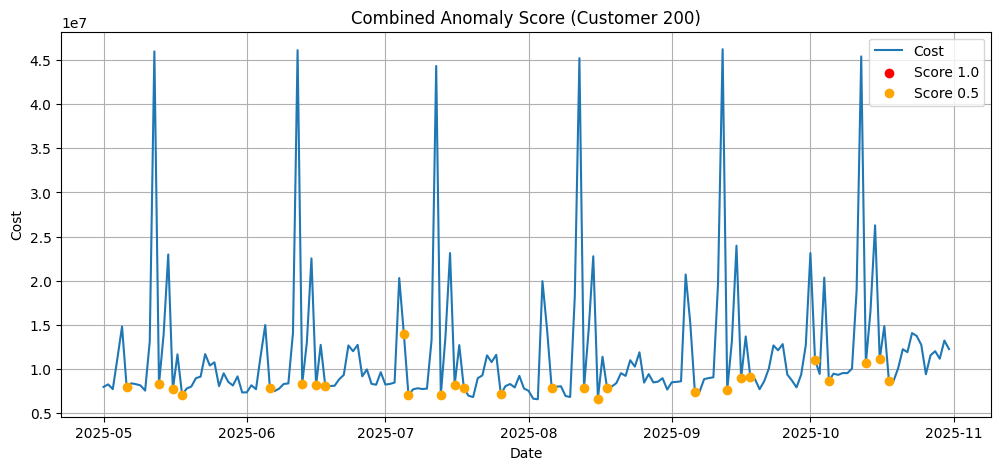

In [72]:
plt.figure(figsize=(12,5))
plt.plot(anomaly_df.index, anomaly_df["Cost"], label="Cost")

# 점수 1.0인 날짜 (강한 이상)
strong = anomaly_df[anomaly_df["score"] == 1.0]
plt.scatter(strong.index, strong["Cost"], color="red", label="Score 1.0", zorder=3)

# 점수 0.5인 날짜 (주의)
weak = anomaly_df[anomaly_df["score"] == 0.5]
plt.scatter(weak.index, weak["Cost"], color="orange", label="Score 0.5", zorder=3)

plt.title(f"Combined Anomaly Score (Customer {cust_id})")
plt.xlabel("Date")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()


In [73]:
detailed = df[
    (df["CustomerID"] == cust_id) &
    (df["Date"].isin(combined_anomaly_dates))
]

grouped = detailed.groupby(["MaskedSub","MeterCategory","MeterSubCategory"])["TotalCost"].sum().sort_values(ascending=False)
print(grouped)


Series([], Name: TotalCost, dtype: float64)


In [74]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Concatenate, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

WINDOW_SIZE = 7
# (X_train.shape[1] = WINDOW_SIZE, X_train.shape[2] = 1)

# 1. Encoder (Attention을 위해 return_sequences=True로 설정)
encoder_inputs = Input(shape=(WINDOW_SIZE, 1))
encoder_lstm = LSTM(32, activation='relu', return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) # encoder_outputs는 모든 시점의 hidden state

# 2. Decoder 시작 (RepeatVector로 시작 토큰 역할을 함)
# 디코더의 초기 상태는 인코더의 최종 상태를 사용 (Seq2Seq의 표준)
decoder_inputs = RepeatVector(WINDOW_SIZE)(state_h) 
decoder_lstm = LSTM(32, activation='relu', return_sequences=True)(decoder_inputs, initial_state=[state_h, state_c])

# 3. Attention Layer
# Query(질문): decoder_lstm의 출력 (현재 디코딩 상태)
# Value(참조값): encoder_outputs (인코더의 모든 출력)
attention_layer = Attention()([decoder_lstm, encoder_outputs])

# 4. Concatenate
# Attention 결과와 Decoder 출력을 결합하여 최종 예측에 활용
decoder_concat_input = Concatenate(axis=-1)([decoder_lstm, attention_layer])

# 5. Output Layer
decoder_outputs = TimeDistributed(Dense(1))(decoder_concat_input)

# 6. Model Definition
attn_model = Model(encoder_inputs, decoder_outputs)
attn_model.compile(optimizer='adam', loss='mse')

print("--- Attention-LSTM Model Summary ---")
attn_model.summary()

# 모델 학습 (X_train, X_train_seq는 기존 LSTM 모델에서 사용한 시퀀스 데이터)
# history_attn = attn_model.fit(
#     X_train_seq, X_train_seq,
#     epochs=50,
#     batch_size=16,
#     validation_data=(X_val_seq, X_val_seq),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
# )

--- Attention-LSTM Model Summary ---


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 7, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_12 (LSTM)                │ [(None, 7, 32), (None,    │           4,352 │ input_layer_6[0][0]        │
│                               │ 32), (None, 32)]          │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector_6               │ (None, 7, 32)             │               0 │ lstm_12[0][1]              │
│ (RepeatVector)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_13 (LSTM)                │ (None, 7, 32)             │           8,320 │ repeat_vector_6[0][0],     │
│                               │                           │                 │ lstm_12[0][1],             │
│                               │                           │                 │ lstm_12[0][2]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_3 (Attention)       │ (None, 7, 32)             │               0 │ lstm_13[0][0],             │
│                               │                           │                 │ lstm_12[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 7, 64)             │               0 │ lstm_13[0][0],             │
│                               │                           │                 │ attention_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_6            │ (None, 7, 1)              │              65 │ concatenate_3[0][0]        │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 12,737 (49.75 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Concatenate, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

WINDOW_SIZE = 7

# 1. Encoder (Attention을 위해 return_sequences=True로 설정)
encoder_inputs = Input(shape=(WINDOW_SIZE, 1))
# encoder_lstm_output, state_h, state_c를 모두 반환
encoder_lstm = LSTM(32, activation='relu', return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 
encoder_states = [state_h, state_c] # Encoder의 최종 상태 (Decoder 초기 상태로 사용)

# 2. Decoder 시작 (RepeatVector로 시작 토큰 역할)
# state_h를 반복하여 Decoder의 입력 시퀀스 형태로 만듭니다.
decoder_inputs = RepeatVector(WINDOW_SIZE)(state_h) 

# Decoder LSTM (initial_state로 Encoder 상태를 받음)
decoder_lstm = LSTM(32, activation='relu', return_sequences=True)(decoder_inputs, initial_state=encoder_states)

# 3. Attention Layer
# Query(현재 디코더 상태)와 Value(인코더의 전체 시퀀스 출력)를 사용
attention_layer = Attention()([decoder_lstm, encoder_outputs])

# 4. Concatenate (Attention 결과와 Decoder 출력을 결합)
decoder_concat_input = Concatenate(axis=-1)([decoder_lstm, attention_layer])

# 5. Output Layer
decoder_outputs = TimeDistributed(Dense(1))(decoder_concat_input)

# 6. Model Definition
attn_model = Model(encoder_inputs, decoder_outputs)
attn_model.compile(optimizer='adam', loss='mse')

print("--- Attention-LSTM Model Defined ---")

--- Attention-LSTM Model Defined ---


In [76]:
# EarlyStopping 콜백 정의
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# 학습 실행
# X_train을 입력(Input)이자 정답(Target)으로 사용합니다 (오토인코더 방식).
history_attn = attn_model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1, # 학습 데이터의 10%를 검증 데이터로 사용
    shuffle=False,
    callbacks=[early_stop]
)

print("✅ Attention-LSTM 학습 완료")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.0462 - val_loss: 0.0032
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0403 - val_loss: 0.0018
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0360 - val_loss: 0.0024
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0344 - val_loss: 0.0047
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0346 - val_loss: 0.0049
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0342 - val_loss: 0.0036
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0337 - val_loss: 0.0028
✅ Attention-LSTM 학습 완료


In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. 재구성 오차 계산
# 테스트 시퀀스 (X_test)에 대한 예측
X_test_pred_attn = attn_model.predict(X_test)

# 재구성 오차 (MSE) 계산
test_mse_attn = np.mean(np.square(X_test_pred_attn - X_test), axis=(1, 2))

# 2. 임계값 적용
# Train MSE 기반 1.5σ 임계값 재계산 (Attention 모델에 맞게)
train_mse_attn = np.mean(np.square(attn_model.predict(X_train) - X_train), axis=(1, 2))
threshold_attn = train_mse_attn.mean() + 1.5 * train_mse_attn.std()

# LSTM 이상 탐지 플래그 (1.5σ 기준)
anomaly_flags_attn = test_mse_attn > threshold_attn
dates_attn_15sigma = ts_original.index[WINDOW_SIZE + split_point : WINDOW_SIZE + split_point + len(test_mse_attn)][anomaly_flags_attn]

# 3. F1-Score 비교 (감소 기준 -30%를 '정답'으로 가정)
# y_true: 감소 기준 (-30%)을 만족하는 날짜
decrease_anomalies_dates = decrease_anomalies.index # execution_count 29에서 계산됨
y_true = ts_original.index.isin(decrease_anomalies_dates)

# y_pred: Attention-LSTM (1.5σ)이 탐지한 날짜
y_pred_attn = ts_original.index.isin(dates_attn_15sigma)

print("\n--- Attention-LSTM F1-Score ---")
print("Threshold (1.5σ):", threshold_attn)
print("Precision:", precision_score(y_true, y_pred_attn))
print("Recall:", recall_score(y_true, y_pred_attn))
print("F1 Score:", f1_score(y_true, y_pred_attn))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- Attention-LSTM F1-Score ---
Threshold (1.5σ): 0.10899138721400917
Precision: 0.42857142857142855
Recall: 0.2222222222222222
F1 Score: 0.2926829268292683


In [18]:
# 이상 날짜의 원본 데이터 필터링
abnormal_raw = df[
    (df["CustomerID"] == cust_id) &
    (df["Date"].isin(anomaly_dates))
]

# Subscription별 비용 집계
subscription_summary = abnormal_raw.groupby("MaskedSub")["TotalCost"].sum().sort_values(ascending=False)

print("📌 이상치 기간 Subscription별 비용:")
print(subscription_summary)


📌 이상치 기간 Subscription별 비용:
MaskedSub
sub_b1d39d071184509f    7.488942e+06
sub_e3ff1810ca25b9bb    6.129722e+06
sub_1533539d89b8cbc2    4.166572e+06
sub_182d35715f9fe7e0    3.464987e+06
sub_756af63108f1c3ab    3.378897e+06
sub_2f5bd66043219799    2.309677e+06
sub_1f1223e5f2fdc818    2.000330e+06
sub_b21326f469ef2b1     1.753090e+06
sub_50b225651f3e5a2e    1.736308e+06
sub_80fbfa7b1aed1314    1.531626e+06
sub_ff07948020ba345f    1.291656e+06
sub_29b2073ffc082be6    1.252797e+06
sub_2122ac65d970dd91    1.132127e+06
sub_85d0d8d52cbb8565    1.109209e+06
sub_1155f8d86a1453f0    9.801919e+05
sub_4f7e0811cd76bd7e    9.771256e+05
sub_ab9762619fd0df4e    9.606736e+05
sub_61dfcb0d288bedce    9.421983e+05
sub_30a696cc2ccf3fdd    8.325897e+05
sub_4c7f6f0283ec7b63    6.448348e+05
sub_afc510aaa625c2de    4.228427e+05
sub_451a4bb404ebe56a    4.205780e+05
sub_99233b3a74af281c    3.551171e+05
sub_ea399ea2ca05c83c    1.970742e+05
sub_367ccce9143e65dc    1.483278e+05
sub_c7a444d47940234d    1.231244e+05
s

In [19]:
target_sub = "sub_abf2f019b0c81eb1"

sub_ts = (
    df[(df["CustomerID"] == cust_id) & (df["MaskedSub"] == target_sub)]
      .groupby("Date")["TotalCost"]
      .sum()
      .sort_index()
)

print(sub_ts.describe())


count    1.840000e+02
mean     3.625480e+06
std      7.702453e+06
min      6.274253e+05
25%      7.357104e+05
50%      2.040097e+06
75%      2.877418e+06
max      4.608796e+07
Name: TotalCost, dtype: float64


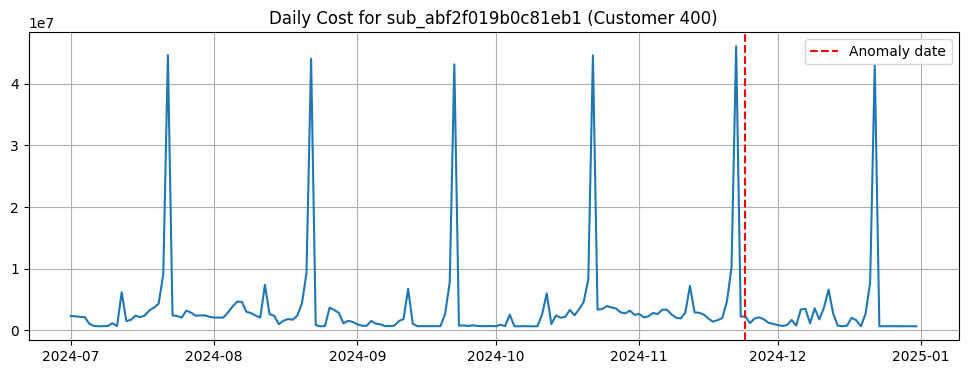

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(sub_ts.index, sub_ts.values)
plt.axvline(anomaly_dates.min(), color="red", linestyle="--", label="Anomaly date")
plt.title(f"Daily Cost for {target_sub} (Customer {cust_id})")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
#  이상 날짜의 원본 데이터 (이미 만들어둔 abnormal_raw 재사용)
# abnormal_raw = df[
#     (df["CustomerID"] == cust_id) &
#     (df["Date"].isin(anomaly_dates))
# ]

# 구독 + MeterCategory + MeterSubCategory별 비용 집계
group_cols = ["MaskedSub", "MeterCategory", "MeterSubCategory"]

anomaly_detail = (
    abnormal_raw
    .groupby(group_cols)["TotalCost"]
    .sum()
    .reset_index()
    .sort_values("TotalCost", ascending=False)
)

print(" 이상 기간 구독 + 카테고리별 비용 상위 20개")
print(anomaly_detail.head(20))


 이상 기간 구독 + 카테고리별 비용 상위 20개
                MaskedSub       MeterCategory            MeterSubCategory  \
349  sub_8989b1472fa52c3c    Virtual Machines                 FSv2 Series   
454  sub_abf2f019b0c81eb1             Storage   Premium SSD Managed Disks   
461  sub_abf2f019b0c81eb1    Virtual Machines                 HXrs Series   
33   sub_24631dfe2bef7f8a  Cognitive Services                Azure OpenAI   
372  sub_91012bd89c3c4f87             Storage                   Bandwidth   
345  sub_8989b1472fa52c3c             Storage  Standard SSD Managed Disks   
620  sub_d92100777e7f2e53    Virtual Machines                 FSv2 Series   
476  sub_ae661815e3543197    Virtual Machines                 Esv5 Series   
340  sub_8989b1472fa52c3c             Storage                    Files v2   
384  sub_91012bd89c3c4f87    Virtual Machines                 Dsv5 Series   
509  sub_c7c4ed8951e5427f    Virtual Machines                 Esv5 Series   
113  sub_379f6bb9f9e5df4f    Virtual Machines   

In [23]:
target_sub = "sub_abf2f019b0c81eb1"  # 확인하고 싶은 MaskedSub ID

sub_detail = (
    abnormal_raw[abnormal_raw["MaskedSub"] == target_sub]
    .groupby(["MeterCategory", "MeterSubCategory"])["TotalCost"]
    .sum()
    .reset_index()
    .sort_values("TotalCost", ascending=False)
)

print(f" {target_sub} 구독의 이상 기간 카테고리별 비용")
print(sub_detail.head(20))


 sub_abf2f019b0c81eb1 구독의 이상 기간 카테고리별 비용
                   MeterCategory            MeterSubCategory     TotalCost
3                        Storage   Premium SSD Managed Disks  6.299623e+06
10              Virtual Machines                 HXrs Series  5.175186e+06
12     Virtual Machines Licenses    Red Hat Enterprise Linux  5.194943e+04
6                        Storage  Standard SSD Managed Disks  4.410932e+04
13               Virtual Network                     Peering  3.727366e+04
0   Microsoft Defender for Cloud     Microsoft Defender CSPM  2.822602e+04
4                        Storage  Standard HDD Managed Disks  1.183398e+04
7                        Storage           Tiered Block Blob  2.330460e+02
1                        Storage                       Files  1.217597e+02
5                        Storage       Standard Page Blob v2  1.030478e+01
2                        Storage                    Files v2  5.062200e-03
8               Virtual Machines                Ddsv5 Serie

In [51]:
total_anomaly_cost = anomaly_detail["TotalCost"].sum()

anomaly_detail["Ratio(%)"] = anomaly_detail["TotalCost"] / total_anomaly_cost * 100

print(" 이상 기간 구독+카테고리별 비용 비중 상위 20개")
print(anomaly_detail.head(20))


 이상 기간 구독+카테고리별 비용 비중 상위 20개
                MaskedSub                  MeterCategory  \
48   sub_2697df3e91ff01b5               Virtual Machines   
168  sub_98f37001440b9a81      Virtual Machines Licenses   
161  sub_98f37001440b9a81               Virtual Machines   
115  sub_98f37001440b9a81                        Storage   
57   sub_98f37001440b9a81            Application Gateway   
4    sub_2697df3e91ff01b5  Azure Database for PostgreSQL   
124  sub_98f37001440b9a81                     Unassigned   
102  sub_98f37001440b9a81           SQL Managed Instance   
121  sub_98f37001440b9a81                        Storage   
14   sub_2697df3e91ff01b5                    Redis Cache   
72   sub_98f37001440b9a81  Azure Database for PostgreSQL   
94   sub_98f37001440b9a81                    Redis Cache   
162  sub_98f37001440b9a81               Virtual Machines   
110  sub_98f37001440b9a81                        Storage   
158  sub_98f37001440b9a81               Virtual Machines   
166  sub_98